In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import optuna

import matplotlib.pyplot as plt

In [2]:
SEED = 69

import os
os.environ['PYTHONHASHSEED']=str(SEED)

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

In [3]:
data = pd.read_parquet("data_with_feats_4xgb.parquet.gzip")

# Choose features

In [4]:
column_to_use = ["annual_inc", "loan_amnt"]  # "fico_average", "emp_length"

In [5]:
data_used_cols = data[column_to_use + ["target"]].dropna()

assert data.shape[0] == data_used_cols.shape[0]

In [6]:
X, y = data_used_cols[column_to_use].values, data_used_cols["target"].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED, stratify=y)

# Calculate hyperparametres

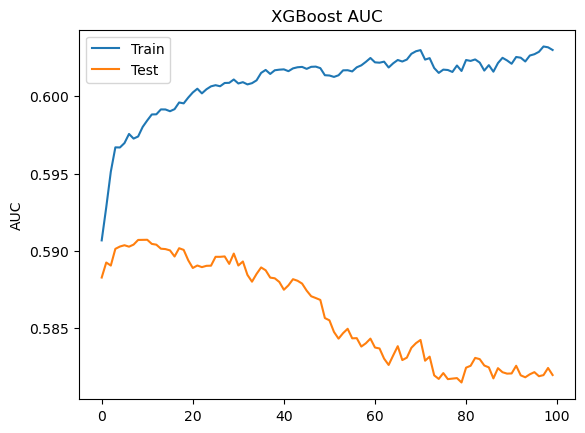

0.55747


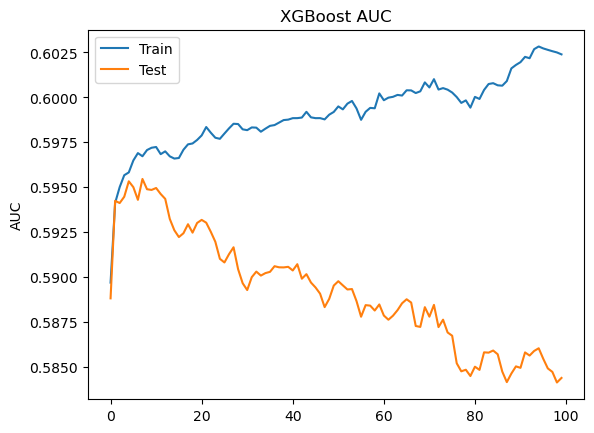

0.5541


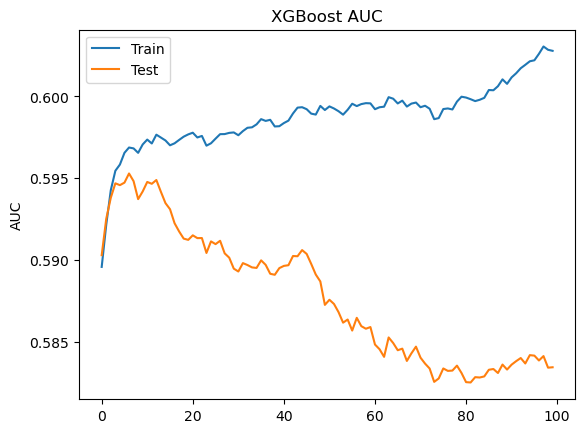

0.5575


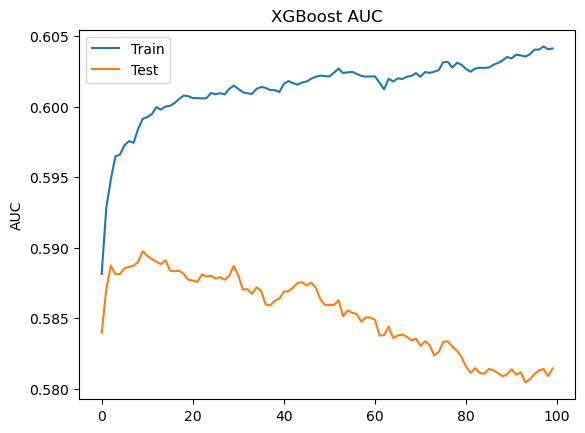

0.55748


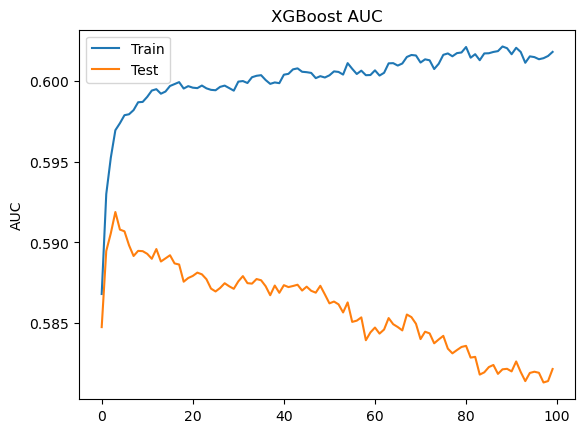

0.5561
0.55653 +- 0.00133


In [11]:
# Create stratified k-fold object
skf = StratifiedKFold(n_splits=5)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.1
}


# Train and test model on each fold
metrics = []
for train_index, test_index in skf.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[test_index]
    y_train, y_val = y_train_val[train_index], y_train_val[test_index]
    
    # Train model
    params['scale_pos_weight'] = (y_train == 0).sum() / (y_train == 1).sum()

    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )

    results = model.evals_result()
    epochs = len(results['validation_0']['auc'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['auc'], label='Train')
    ax.plot(x_axis, results['validation_1']['auc'], label='Test')
    ax.legend()
    plt.ylabel('AUC')
    plt.title('XGBoost AUC')
    plt.show()
    
    # Test model
    y_pred = model.predict(X_test)
    metric = roc_auc_score(y_test, y_pred)
    metrics.append(
        metric
    )
    print(
        round(
            metric, 5
        )
    )
    
print(
    f"{round(np.mean(metrics), 5)} +- {round(np.std(metrics), 5)}"
)

In [ ]:
# 0.56276 +- 0.01758
X.shape

(837536, 2)